# Introduction: the BSM model

#### Roland Grinis  -  Researcher at MIPT Nuclear Physics Methods lab  -  CTO at GrinisRIT (grinisrit.com)

In [3]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline
torch.manual_seed(987654);

If you like dark plots:

In [4]:
import seaborn as sns
sns.set_style('darkgrid',
                {'axes.facecolor': '.2',
                'figure.facecolor': '0.1',
                'text.color': '.9',
                'grid.color': '.5',
                'xtick.color': '.9',
                'ytick.color': '.9'})

## 1. Introduction

### 1.1 What are *derivatives*?

Assets include bonds, stocks, commodities, FX rates, cryptocurrencies etc. 

Some examples:

#### Zero-coupon bond
A contract worth $P(t,T)$ at time $t$ that pays $P(T,T) = 1$ at maturity $t=T$

In [5]:
N = 365 # Actual/365 day counting convention
t = torch.linspace(0,1,N) # in years, maturity T = 1
time_to_maturity = 1 - t

Continuously-compounded spot interest rate 
$$
r(t,T) = - \frac{\ln P(t,T)}{T-t}
$$

In [6]:
spot_interest_rate = 0.01 * torch.rand(N) + 0.05 * torch.sigmoid(100 * (t-0.5))  # rate hike
bond = torch.exp(- time_to_maturity * spot_interest_rate)

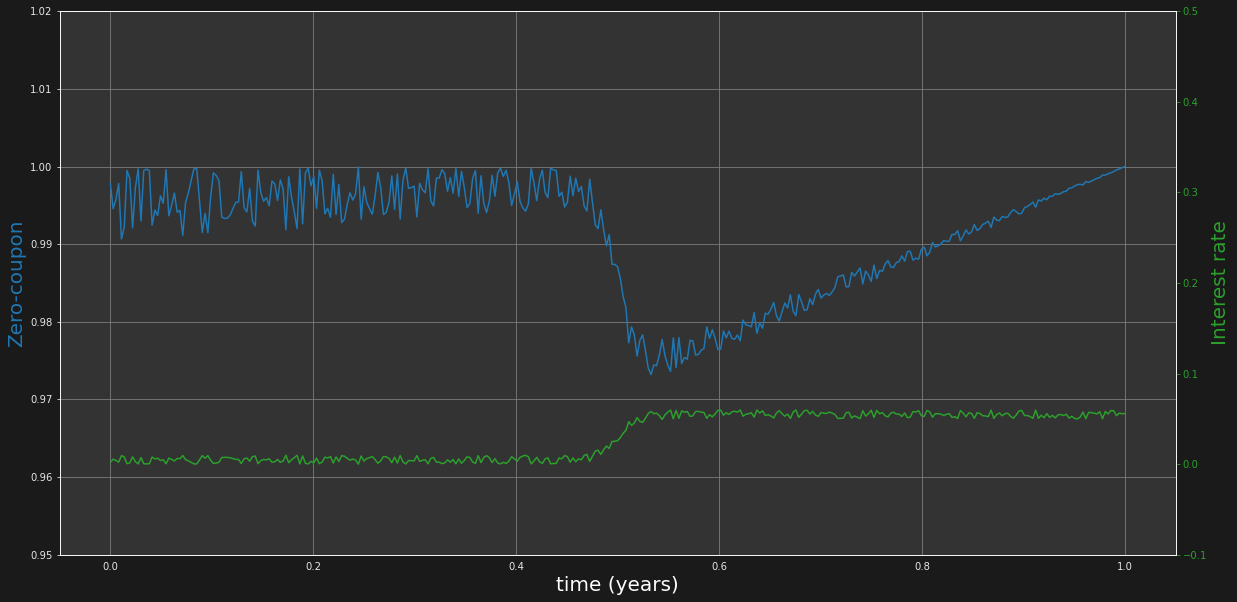

In [80]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_xlabel('time (years)', color='white', fontsize=20)
ax1.set_ylabel('Zero-coupon', color='C0', fontsize=20)
ax1.plot(t.numpy(), bond.numpy(), 'C0')
ax1.set_ylim([0.95,1.02])

ax2 = ax1.twinx() 
ax2.grid(False)
ax2.set_ylabel('Interest rate', color='C2', fontsize=20)
ax2.plot(t.numpy(),spot_interest_rate.numpy(),color='C2')
ax2.set_ylim([-0.1,0.5])
ax2.tick_params(axis='y', colors='C2')

plt.show()

#### Zero-bond curve 
This is the map:

$$
T \rightarrow P(t,T), \quad T>t
$$ 

with corresponding continuously-compounded zero-coupon curve:

$$
T \rightarrow r(t,T), \quad T>t
$$ 

sometimes simply referred to as the *yield curve*. 

There are many different curves, e.g.
[US Libor](https://tradingeconomics.com/united-states/interbank-rate),
[US Treasuries](https://tradingeconomics.com/united-states/government-bond-yield) etc.



#### Risky assets
Stock prices $S(t)$ and everything else is classified as *risky*. At the beginning of 20th century Bachelier proposed to model them as Browmian motion:

In [60]:
K = 100
S = K + (0.5 + 5.*torch.randn(N)).cumsum(0) # alpha = 0.5 and vol = 5.0

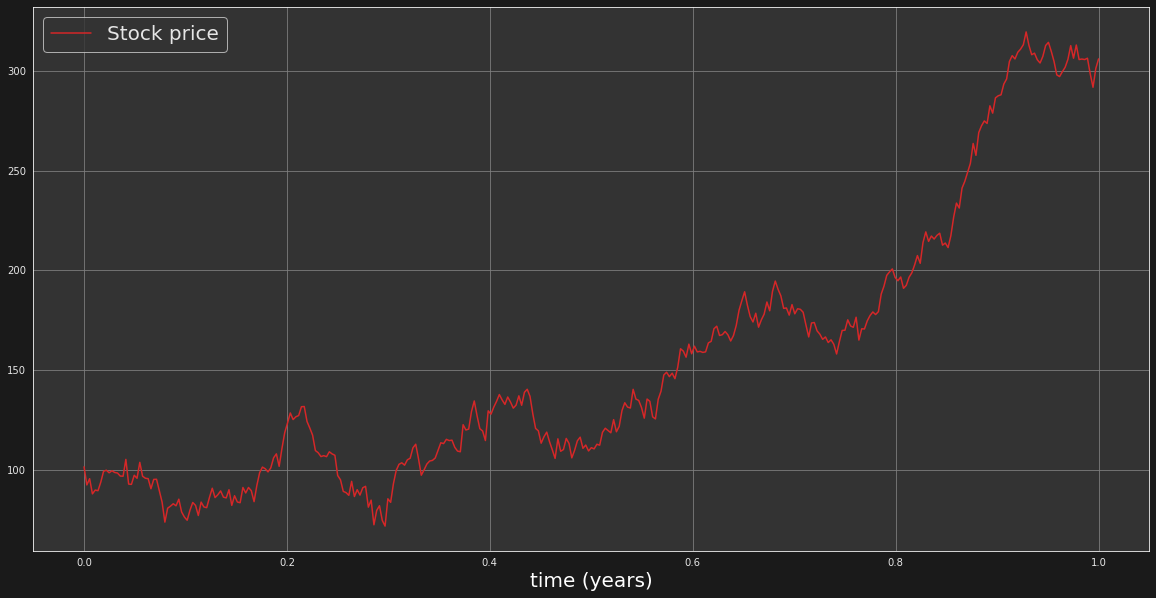

In [67]:
plt.figure(figsize=(20,10))
plt.plot(t.numpy(), S.numpy(),'C3',markersize=30, label='Stock price')
plt.legend(fontsize=20)
plt.xlabel('time (years)', color='white', fontsize=20)
plt.show()

Mandelbrot noted in the 1960s that Brownian motion fails to produce *fat tails* typically observed in stock returns distribution. Modelling improvements include *stochastic volatility* and *jump processes*.

#### Financial Derivatives
It is a contract between a Party (P) and its Counter-Party (CP) entered at time $t=t_0$ and settleted:
* at maturity $t=T$ (European style)
* at any time $t \leq T$ (American style)
* at some specified exercise dates $t_1, t_2, \dots, T$ (Bermudan style)

according to a *payoff* function that depends on one or several underlying securities (assets, or other derivatives). 

The payoff might depend on the value of the underlyings at exercise date (vanilla contracts) or on the whole path between $t_0$ and maturity $T$ (exotic contracts).

Derivatives can be traded directly between P and CP - *over-the-counter* (OTC) contracts - or via a Central Counter Party (CCP), e.g. on an exchange such as CME, or a clearing house like the LCH.  

Examples:

#### Forwards/Futures

The *forward* is an OTC contract that fixes the price of security $S_t$ at the *forward rate*:
$$
F(t,T) = \frac{S_t}{P(t,T)}
$$
Futures are exchange traded standardized versions of forwards. 

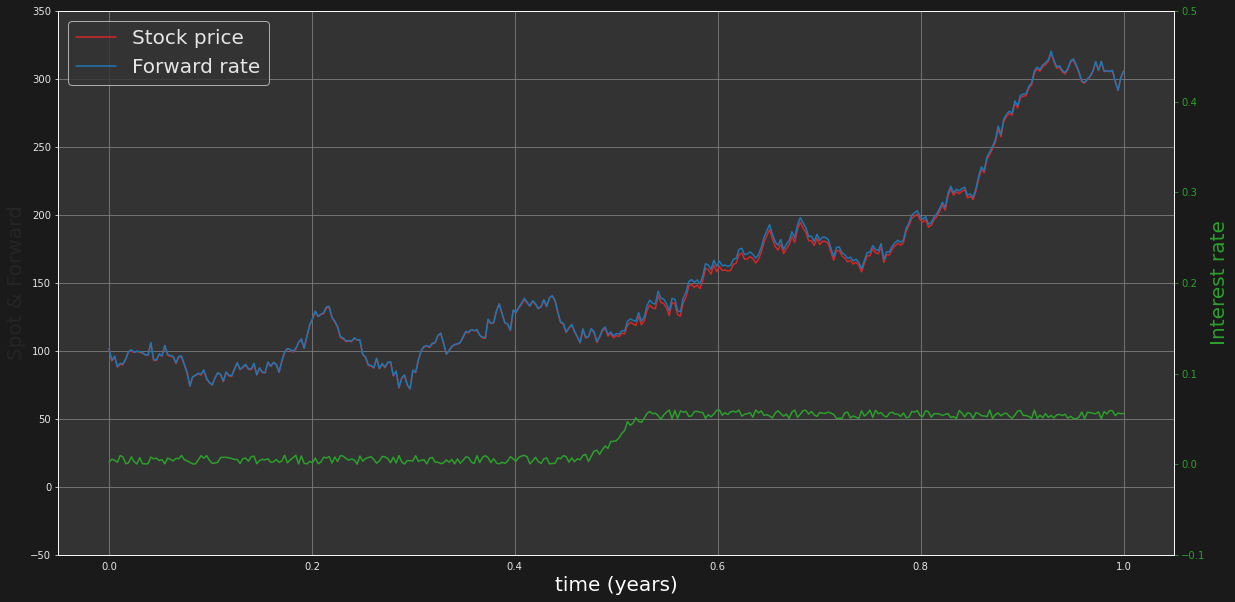

In [81]:
F = S / bond 

fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_xlabel('time (years)', color='white', fontsize=20)
ax1.plot(t.numpy(), S.numpy(),'C3',markersize=30, label='Stock price')
ax1.plot(t.numpy(), F.numpy(), 'C0', markersize=30, label='Forward rate')
ax1.set_ylabel('Spot & Forward', fontsize=20)
ax1.set_ylim([-50,350])
ax1.legend(loc='upper left',fontsize=20)

ax2 = ax1.twinx() 
ax2.grid(False)
ax2.set_ylabel('Interest rate', color='C2', fontsize=20)
ax2.plot(t.numpy(),spot_interest_rate.numpy(),color='C2')
ax2.set_ylim([-0.1,0.5])
ax2.tick_params(axis='y', colors='C2')

plt.show()

#### Swaps

An *interest rate swap* is a contract that exchange a floating rate payments made at dates $\mathcal{T} = \{ T_0,T_1,\dots,T_n\}$ for a fixed *forward swap rate* given by:
$$
S_{\mathcal{T}}(t) = \frac{P(t,T_1) - P(t,T_n)}{A_{\mathcal{T}}(t)}
$$
where 
$$
A_{\mathcal{T}}(t) = \sum_{i=1}^{n}\tau_iP(t,T_i), \quad \tau_i = T_i - T_{i-1}
$$
is the *annuity*.

Forwards and swaps are example of *linear* products. Options represent another class of derivatives whose value depends non-linearly on the price of the underlying.  

#### Options

A *call option* gives the right (but not the obligation) to buy a security $S_{t_e}$ at exercise date $t_e$ for a fixed price $K$, *the strike*. The payoff is given by:
$$
(S_{t_e} - K)^{+} = \max\{S_{t_e} - K,0\}
$$
A *put option* gives the right (but not the obligation) to sell a security $S_{t_e}$ at exercise date $t_e$ for the strike $K$. The payoff in this case is:
$$
(K - S_{t_e})^{+} = \max\{K - S_{t_e},0\}
$$ 

Put options are popular for hedging against a sudden drop in value of an investement in a risky asset.

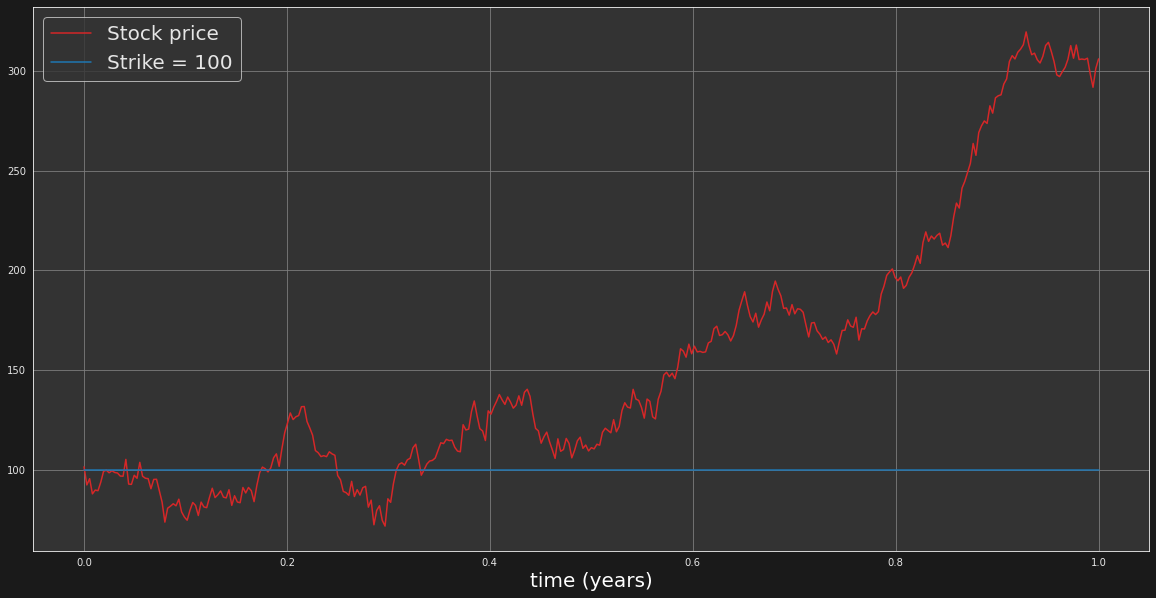

In [86]:
plt.figure(figsize=(20,10))
plt.plot(t.numpy(), S.numpy(),'C3',markersize=30, label='Stock price')
plt.plot(t.numpy(), K*torch.ones_like(S).numpy(),'C0',markersize=30, label=f'Strike = {K}')
plt.legend(fontsize=20)
plt.xlabel('time (years)', color='white', fontsize=20)
plt.show()

#### Moneyness 
If the forward rate $F(t,T) = K$ we say that the option is *at-the-money* (ATM). For a call:
* if $K < F(t,T)$ the option is *in-the-money* (ITM)

* if $K > F(t,T)$ the option is *out-of-the-money* (OTM)

For a put it's the other way round. 

#### Swaptions
A *receiver swaption* gives the right (but not the obligation) to enter a swap where the floating rate payments will be exchanged for a fixed rate $K$. It is essentially a call option on the forward swap rate $S_{\mathcal{T}}(t)$ with strike $K$. 

A *payer swaption* gives the right (but not the obligation) to enter a swap where a fixed rate $K$ will be exchanged for floating rate payments. It is a put 

*Callables* are popular products that combine a swap together with an ATM Bermudan payer swaption enabling the holder to get out of fixed rate payements if the interest rates fall.


### 1.2 What is a fair value of a derivative contract?

The answer is easy: it is *always* the value the market settles to as a result of demand and supply dynamics. 

### Who are *quants*?

Front office: 
* quant traders
* strategist (strats)
* quant modellers 
* quant developers

Back office:
* risk management
* regulatory 

## References

* Seydel, R.U. *Tools for Computational Finance*, 6th edition, Springer V., London (2017)
* Shreve, S.E. Stochastic Calculus for Finance I & II, Springer, New York (2004)
* Grzelak, L.A. et al. *Mathematical Modeling and Computation in Finance: With Exercises and Python and MATLAB Computer Codes*, World Scientific Pub. (2019)